In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [ ]:
import os

In [ ]:
# import shutil

# # Path to the extracted Kaggle dataset
# kaggle_dataset_path = path

# # Destination path in your Google Drive
# drive_dataset_path = "/content/drive/MyDrive/Dissertation/fer-2013-dataset"

# # Copy the full dataset recursively
# shutil.copytree(kaggle_dataset_path, drive_dataset_path)

# print("Dataset copied to Google Drive at:", drive_dataset_path)

In [ ]:
import os

for fold in ['train',"test"]:
  image_counts_train = {}
  train_path = f'/content/drive/MyDrive/Dissertation/fer-2013-dataset/{fold}'
  classes_train = sorted(os.listdir(train_path))
  for cls in classes_train:
      cls_folder = os.path.join(train_path, cls)
      count = len(os.listdir(cls_folder))
      image_counts_train[cls] = count
  print(fold.capitalize())
  print(image_counts_train)


Train
{'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
Test
{'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


In [ ]:
import os

for fold in ['Train',"Test"]:
  image_counts_train = {}
  train_path = f'/content/drive/MyDrive/Dissertation/affectnet_cleaned/{fold}'
  classes_train = sorted(os.listdir(train_path))
  for cls in classes_train:
      cls_folder = os.path.join(train_path, cls)
      count = len(os.listdir(cls_folder))
      image_counts_train[cls] = count
  print(fold.capitalize())
  print(image_counts_train)


Train
{'anger': 1500, 'disgust': 1229, 'fear': 1512, 'happy': 2340, 'neutral': 2758, 'sad': 3091, 'surprise': 2119}
Test
{'anger': 1718, 'disgust': 1248, 'fear': 1664, 'happy': 2704, 'neutral': 2368, 'sad': 1584, 'surprise': 1920}


In [ ]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, ConcatDataset, WeightedRandomSampler, DataLoader
from transformers import BeitFeatureExtractor
import torch

# 1. Label map
EMOTION_LABELS = {
    'anger': 0, 'disgust': 1, 'fear': 2,
    'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6
}



# 2. Setup feature extractor
feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-large-patch16-224-pt22k-ft22k")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# 3. AffectNet Dataset
class AffectNetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        for emotion in os.listdir(root_dir):
            if emotion.lower() not in EMOTION_LABELS:
                continue
            emotion_folder = os.path.join(root_dir, emotion)
            for img in os.listdir(emotion_folder):
                if img.lower().endswith(('.jpg', '.png')):
                    self.samples.append((os.path.join(emotion_folder, img), EMOTION_LABELS[emotion.lower()]))
        self.transform = transform

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform: image = self.transform(image)
        return image, label

# 4. FER-2013 Dataset
class FER2013Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        for emotion in os.listdir(root_dir):
            if emotion.lower() not in EMOTION_LABELS:
                continue
            emotion_folder = os.path.join(root_dir, emotion)
            for img in os.listdir(emotion_folder):
                if img.lower().endswith(('.jpg', '.png')):
                    self.samples.append((os.path.join(emotion_folder, img), EMOTION_LABELS[emotion.lower()]))
        self.transform = transform

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform: image = self.transform(image)
        return image, label

# 5. RAF-DB Dataset
class RAFDBDataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None):
        self.samples = []
        df = pd.read_csv(csv_path)

        for _, row in df.iterrows():
            label = int(row['label'])        # 1–7 in CSV
            filename = row['image']
            img_path = os.path.join(img_dir, str(label), filename)  # Folder = label

            if os.path.exists(img_path):
                self.samples.append((img_path, label - 1))  # Convert to 0–6
            else:
                print(f"Missing: {img_path}")  # Optional debug log

        print("Loaded samples:", len(self.samples))
        self.transform = transform

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# # 6. Paths to your datasets
affectnet_train_path = '/content/drive/MyDrive/Dissertation/affectnet_cleaned/Train'
fer_train_path       = '/content/drive/MyDrive/Dissertation/fer-2013-dataset/train'
raf_img_dir          = '/content/drive/MyDrive/Dissertation/raf-db-dataset/DATASET/train'
raf_csv_path         = '/content/drive/MyDrive/Dissertation/raf-db-dataset/train_labels.csv'


# 7. Create datasets
affectnet_ds = AffectNetDataset(affectnet_train_path, transform=transform)
fer_ds       = FER2013Dataset(fer_train_path, transform=transform)
raf_ds       = RAFDBDataset(raf_img_dir, raf_csv_path, transform=transform)

# 8. Merge all datasets
full_train_dataset = ConcatDataset([affectnet_ds, fer_ds, raf_ds])

# 9. Balanced sampler
all_labels = [label for _, label in full_train_dataset]
class_counts = torch.bincount(torch.tensor(all_labels), minlength=7).float()
weights = 1.0 / class_counts
sample_weights = [weights[label] for _, label in full_train_dataset]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# 10. DataLoader

train_loader = DataLoader(
    full_train_dataset,
    batch_size=64,
    sampler=sampler,
    num_workers=8,       # Try 2–4 (or 8 if you're on A100/Colab Pro+)
    pin_memory=True,     # Faster transfer to GPU
    prefetch_factor=2,   # Improves throughput
    persistent_workers=True
)


In [ ]:
# 2. Paths for test data
affectnet_test_path = '/content/drive/MyDrive/Dissertation/affectnet_cleaned/Test'
fer_test_path       = '/content/drive/MyDrive/Dissertation/fer-2013-dataset/test'
raf_test_img_dir    = '/content/drive/MyDrive/Dissertation/raf-db-dataset/DATASET/test'
raf_test_csv_path   = '/content/drive/MyDrive/Dissertation/raf-db-dataset/test_labels.csv'


# 3. Define test datasets
affectnet_test_ds = AffectNetDataset(affectnet_test_path, transform=val_transform)
fer_test_ds       = FER2013Dataset(fer_test_path, transform=val_transform)
raf_test_ds       = RAFDBDataset(raf_test_img_dir, raf_test_csv_path, transform=val_transform)

# 4. Merge all into test dataset
full_test_dataset = ConcatDataset([affectnet_test_ds, fer_test_ds, raf_test_ds])

# 5. Test DataLoader (no sampler)

test_loader = DataLoader(
    full_test_dataset,
    batch_size=64,
    sampler=sampler,
    num_workers=8,       # Try 2–4 (or 8 if you're on A100/Colab Pro+)
    pin_memory=True,     # Faster transfer to GPU
    prefetch_factor=2,   # Improves throughput
    persistent_workers=True
)

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Function to count class distribution
def count_classes(dataset):
    label_counter = Counter()
    for _, label in dataset:
        label_counter[label] += 1
    return dict(label_counter)

# Get emotion names in order of label
emotion_names = list(EMOTION_LABELS.keys())
label_id_to_name = {v: k for k, v in EMOTION_LABELS.items()}

# Training set analysis
train_counts = count_classes(full_train_dataset)
train_counts_named = {label_id_to_name[k]: v for k, v in sorted(train_counts.items())}

# Test set analysis
test_counts = count_classes(full_test_dataset)
test_counts_named = {label_id_to_name[k]: v for k, v in sorted(test_counts.items())}

# Print summary
print("Train Class Counts:")
for cls, count in train_counts_named.items():
    print(f"{cls:<10}: {count}")
print("\n Test Class Counts:")
for cls, count in test_counts_named.items():
    print(f"{cls:<10}: {count}")

# Optional: imbalance analysis
train_total = sum(train_counts.values())
train_max = max(train_counts.values())
train_min = min(train_counts.values())
print(f"\nTrain total: {train_total}, Max: {train_max}, Min: {train_min}, Max/Min ratio: {train_max/train_min:.2f}")

# Optional: imbalance analysis
test_total = sum(test_counts.values())
test_max = max(test_counts.values())
test_min = min(test_counts.values())
print(f"\nTest total: {test_total}, Max: {test_max}, Min: {test_min}, Max/Min ratio: {test_max/test_min:.2f}")


Train Class Counts:
anger     : 1500
disgust   : 1665
fear      : 5609
happy     : 9555
neutral   : 7723
sad       : 7921
surprise  : 5290

 Test Class Counts:
anger     : 1718
disgust   : 1359
fear      : 2688
happy     : 4478
neutral   : 3601
sad       : 2831
surprise  : 2751

Train total: 39263, Max: 9555, Min: 1500, Max/Min ratio: 6.37

Test total: 19426, Max: 4478, Min: 1359, Max/Min ratio: 3.30


In [ ]:
import random

def show_one_image_per_class(dataset, label_map):
    """
    Show one random image from each class in the dataset.

    Args:
        dataset: A PyTorch Dataset or ConcatDataset that returns (image, label)
        label_map: Dictionary mapping label indices to class names
    """
    shown_classes = set()
    class_to_image = {}

    # Shuffle indices to get randomness
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    for idx in indices:
        item = dataset[idx]
        image = item[0] if isinstance(item, tuple) else item['pixel_values']
        label = item[1] if isinstance(item, tuple) else item['labels']

        if label not in shown_classes:
            class_to_image[label] = image
            shown_classes.add(label)

        if len(shown_classes) == len(label_map):
            break

    # Plot
    plt.figure(figsize=(15, 5))
    for i, (label, img_tensor) in enumerate(sorted(class_to_image.items())):
        img = img_tensor.clone().detach().numpy().transpose(1, 2, 0)
        img = img * 0.5 + 0.5  # De-normalize (mean=0.5, std=0.5)
        img = img.clip(0, 1)

        plt.subplot(1, len(label_map), i + 1)
        plt.imshow(img)
        plt.title(label_map[label])
        plt.axis('off')

    plt.tight_layout()
    plt.show()


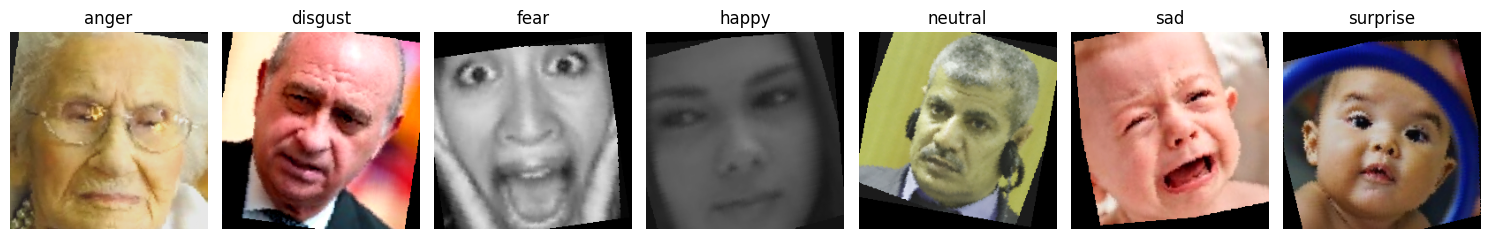

In [ ]:
# Label mapping (already used in your project)
label_map = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

show_one_image_per_class(full_train_dataset, label_map)



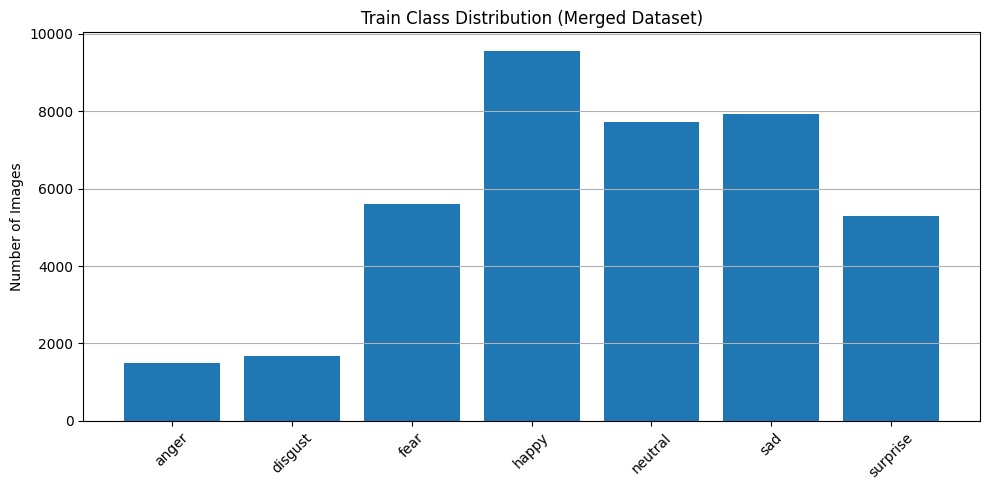

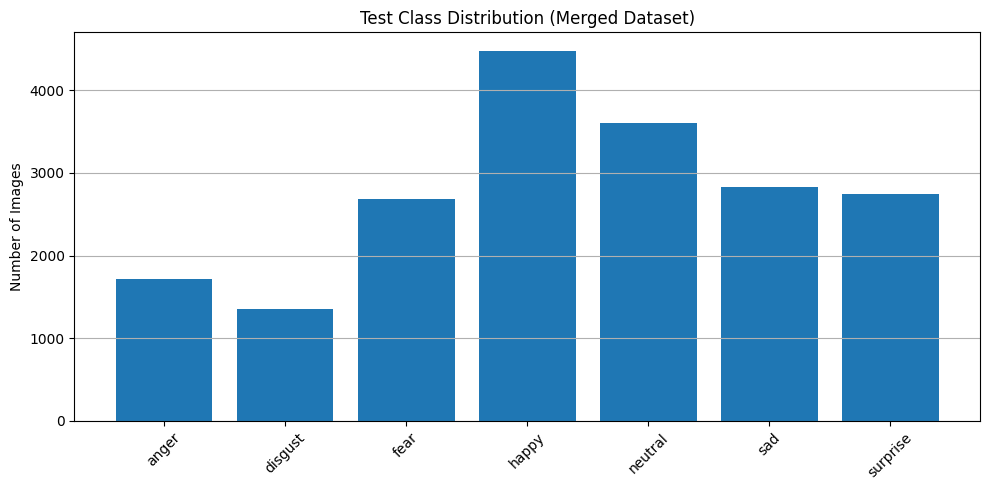

In [ ]:
def plot_class_distribution(counts_dict, title):
    labels = list(counts_dict.keys())
    values = list(counts_dict.values())

    plt.figure(figsize=(10, 5))
    plt.bar(labels, values)
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_counts_named, "Train Class Distribution (Merged Dataset)")
plot_class_distribution(test_counts_named, "Test Class Distribution (Merged Dataset)")


In [ ]:
import numpy as np
import torch
from torch.nn import functional as F
from transformers import (
    BeitForImageClassification,
    BeitFeatureExtractor,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers.trainer_callback import TrainerCallback
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import os


model = BeitForImageClassification.from_pretrained(
    "microsoft/beit-large-patch16-224-pt22k-ft22k",
    ignore_mismatched_sizes=True,  # <-- This fixes the classification head mismatch
   num_labels=7
)


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([7, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compute class weights from train dataset
def compute_class_weights(dataset, num_classes=7):
    label_counts = [0] * num_classes
    for _, label in dataset:
        label_counts[label] += 1
    total = sum(label_counts)
    weights = [total / (num_classes * count) for count in label_counts]
    return torch.tensor(weights, dtype=torch.float)

class_weights = compute_class_weights(full_train_dataset).to("cuda")

In [ ]:
# Focal Loss
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()

focal_loss = FocalLoss(gamma=2, weight=class_weights)

In [ ]:
# Custom Trainer with focal loss + ReduceLROnPlateau
class CustomTrainer(Trainer):
    def __init__(self, *args, lr_scheduler=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr_scheduler = lr_scheduler

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(pixel_values=inputs["pixel_values"])
        logits = outputs.logits
        loss = focal_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

    def training_step(self, *args, **kwargs):
        step_output = super().training_step(*args, **kwargs)
        if self.lr_scheduler:
            self.lr_scheduler.step(step_output.detach().cpu().item())
        return step_output

# Early stopping + ReduceLROnPlateau callback (manual)
class LRSchedulerCallback(TrainerCallback):
    def __init__(self, scheduler):
        self.scheduler = scheduler
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            loss = metrics.get('eval_loss')
            if loss is not None:
                self.scheduler.step(loss)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(optimizer=torch.optim.AdamW(model.parameters(), lr=2e-5),
                              mode='min', patience=2, factor=0.5, verbose=True)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


In [ ]:
class HuggingFaceWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return {
            'pixel_values': img,
            'labels': label
        }

train_dataset = HuggingFaceWrapper(full_train_dataset)  # CSV-based loader
eval_dataset = HuggingFaceWrapper(full_test_dataset)


In [ ]:
training_args = TrainingArguments(
    output_dir="./beit_emotion_checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    num_train_epochs=20,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True,
    dataloader_num_workers=8,
    report_to="none"  # set to 'wandb' or 'tensorboard' if needed
)


In [ ]:
# 10. Trainer with all components
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3),
        LRSchedulerCallback(scheduler=reduce_lr)
    ],
    lr_scheduler=reduce_lr
)


trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.568200,0.765426,0.645218,0.611012,0.624249,0.606830
2,0.472400,0.693803,0.694842,0.672362,0.666796,0.655049
3,0.388500,0.796632,0.701277,0.672859,0.675668,0.659800
4,0.301900,0.778431,0.716617,0.685937,0.691389,0.681683
5,0.246000,0.953430,0.717389,0.690794,0.686160,0.684364
6,0.195600,1.021819,0.737259,0.712387,0.700680,0.701219
7,0.155600,1.219144,0.731751,0.717736,0.691619,0.697147
8,0.155000,1.029514,0.739164,0.710864,0.702282,0.705407
9,0.110200,1.194075,0.736127,0.715443,0.697310,0.700157
10,0.087100,1.289418,0.737053,0.716836,0.697479,0.702879


TrainOutput(global_step=6754, training_loss=0.2660065509173727, metrics={'train_runtime': 24540.5297, 'train_samples_per_second': 31.998, 'train_steps_per_second': 0.5, 'total_flos': 1.1835279637977507e+20, 'train_loss': 0.2660065509173727, 'epoch': 11.0})

In [ ]:
metrics = trainer.evaluate()
print(metrics)



{'eval_loss': 1.0287591218948364, 'eval_accuracy': 0.7412231030577576, 'eval_precision': 0.7128794563094978, 'eval_recall': 0.7041746853398082, 'eval_f1': 0.7073485071624324, 'eval_runtime': 334.4566, 'eval_samples_per_second': 58.082, 'eval_steps_per_second': 1.818, 'epoch': 11.0}


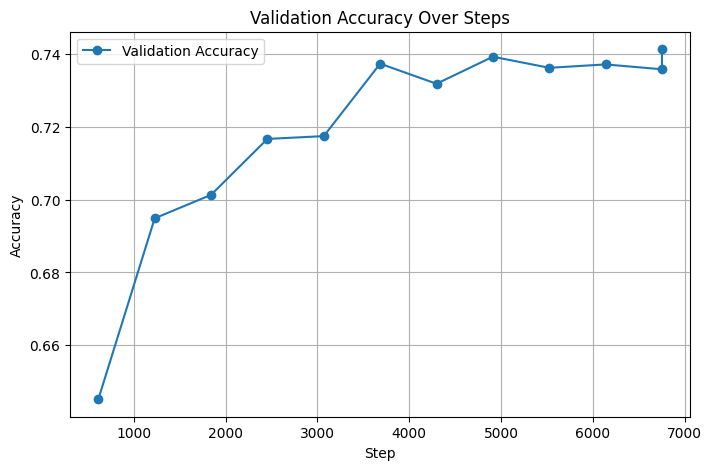

In [ ]:
# Convert logs to DataFrame
logs = pd.DataFrame(trainer.state.log_history)

# Drop rows without accuracy or loss
acc_logs = logs.dropna(subset=["eval_accuracy"])
loss_logs = logs.dropna(subset=["loss"])

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(acc_logs["step"], acc_logs["eval_accuracy"], label="Validation Accuracy", marker='o')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Steps")
plt.grid(True)
plt.legend()
plt.show()


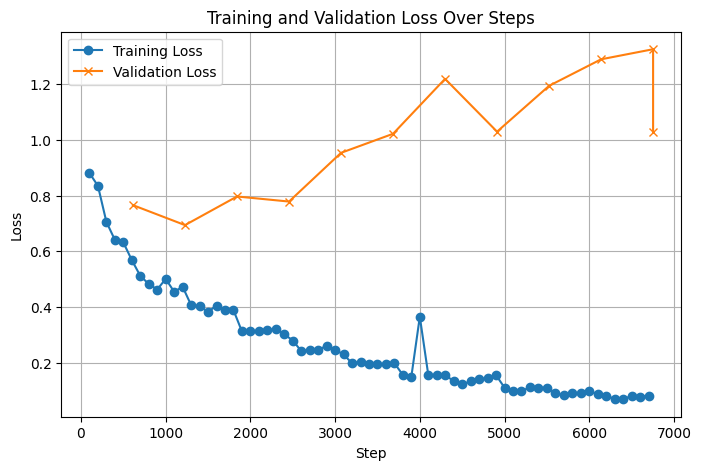

In [ ]:
# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(loss_logs["step"], loss_logs["loss"], label="Training Loss", marker='o')
eval_loss_logs = logs.dropna(subset=["eval_loss"])
plt.plot(eval_loss_logs["step"], eval_loss_logs["eval_loss"], label="Validation Loss", marker='x')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Steps")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# ---- Load Model ----
model.save_pretrained("/content/drive/MyDrive/Dissertation/Testing_models/beit-fer-affectnet-rafdb-v1")


In [ ]:
# ---- Load Model ----
model = BeitForImageClassification.from_pretrained("/content/drive/MyDrive/Dissertation/Testing_models/beit-fer-affectnet-rafdb-v1")

In [ ]:
id2label = {i: label for label, i in EMOTION_LABELS.items()}

In [ ]:
import matplotlib.pyplot as plt

def show_prediction(model, dataset, idx=0):
    model.eval()
    item = dataset[idx]
    img = item['pixel_values'].unsqueeze(0).to(model.device)
    label = item['labels']

    with torch.no_grad():
        outputs = model(img)
        pred = outputs.logits.argmax(dim=1).item()

    plt.imshow(item['pixel_values'].permute(1, 2, 0).cpu() * 0.5 + 0.5)
    plt.title(f"True: {id2label[label]}, Pred: {id2label[pred]}")
    plt.axis('off')
    plt.show()


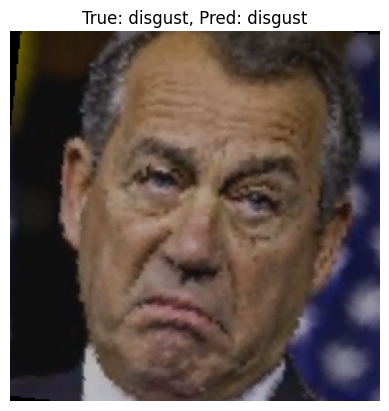

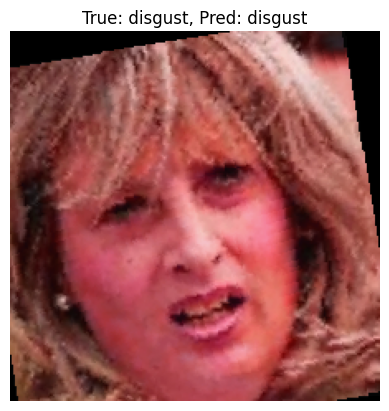

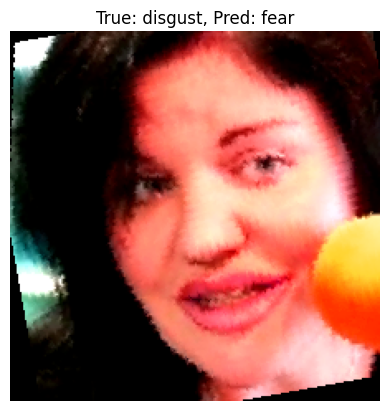

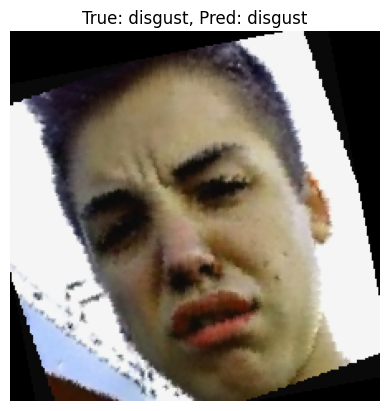

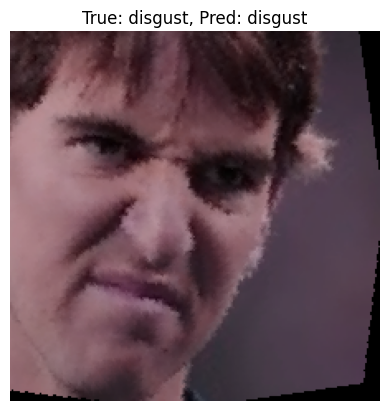

In [ ]:
for i in range(5):
    show_prediction(model, eval_dataset, idx=i)

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_predictions(model, dataloader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['pixel_values'].to(model.device)
            targets = batch['labels'].to(model.device)

            outputs = model(pixel_values=inputs)
            predicted = outputs.logits.argmax(dim=1)

            preds.extend(predicted.cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return np.array(labels), np.array(preds)


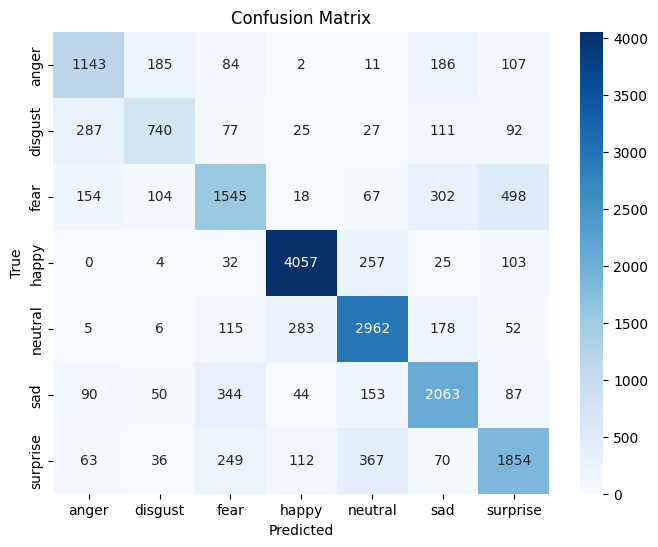

In [ ]:
from torch.utils.data import DataLoader

# Wrap eval_dataset into a DataLoader
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

# Then call the get_predictions function
true_labels, pred_labels = get_predictions(model, eval_loader)

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
# Per-class accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)
print("Per-Class Accuracy:")
for i, acc in enumerate(class_acc):
    print(f"{id2label[i]}: {acc:.2%}")


Per-Class Accuracy:
anger: 66.53%
disgust: 54.45%
fear: 57.48%
happy: 90.60%
neutral: 82.25%
sad: 72.87%
surprise: 67.39%


In [ ]:
# Full classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=[id2label[i] for i in range(len(id2label))]))


Classification Report:
              precision    recall  f1-score   support

       anger       0.66      0.67      0.66      1718
     disgust       0.66      0.54      0.60      1359
        fear       0.63      0.57      0.60      2688
       happy       0.89      0.91      0.90      4478
     neutral       0.77      0.82      0.80      3601
         sad       0.70      0.73      0.72      2831
    surprise       0.66      0.67      0.67      2751

    accuracy                           0.74     19426
   macro avg       0.71      0.70      0.71     19426
weighted avg       0.74      0.74      0.74     19426

